# ODE-BVP's: Shooting Method
---

GENERAL PROBLEM: solve the 2-point boundary value problem

\begin{align}
  y''(x) = f(x, y(x), y'(x))
\end{align}

with boundary conditions

\begin{align}
  & \alpha_{1}y(a) + \beta_{1}y'(a) = g_{1}
  \\
  & \alpha_{2}y(b) + \beta_{2}y'(b) = g_{2}
\end{align}

Cases to consider:
- a. Dirichlet boundary conditions: $\beta_{1}=\beta_{2}=0$.
- b. Neumann boundary conditions: $\alpha_{1}=\beta_{2}=0$ or $\alpha_{2}=\beta_{1}=0$
- c. Mixed boundary conditions: any other combinations

IDEA: guess initial conditions at one boundary, propagating the solution to the other boundary, and then check whether the boundary conditions are satisfied. If they are not, adjust the initial conditions and try again (analogous to a root finding procedure). Repeat until a solution is obtained to the desired precision.

PRE-REQUISITES:
- ODE-IVP's (Euler, Runge-Kutta, explicit methods)
- Solving systems of linear equations (Gaussian elimination, LU factorization)
- Root finding methods for systems of non-linear equations (bisection, secant, Newton-Raphson methods)

REFERENCES:
- [1] Burden and Faires, *Numerical Analysis, 7th edition*.
- [2] Press et al, *Numerical Recipes, 3rd edition*.
- [3] Stoer and Bulirsch, *Introduction to Numerical Analysis, 2nd edition*.
- [4] Keller, *Numerical Methods for Two-Point Boundary-Value Problems*.

## 1. Summary of the method

We start by considering a generic 2nd-order, non-linear, 2-point BVP with Dirichlet boundary conditions:

\begin{align}
  u''(x) = f(x, u(x), u'(x))
  \quad;\quad u(a) = u_{a}
  \quad,\quad u(b) = u_{b}.
\end{align}

(READER'S NOTE: first-order equations only need one piece of data to determine a unique solution, and so 2-pt BVP's do not arise for such equations, without risking over-determining the solutions. Linear 2nd-order BVP's can be solved analytically, see [1], and so are of little interest to us here. Hence we start with 2nd-order, non-linear BVP's. We first consider the case of Dirichlet boundary conditions for convenience. The method is simpler to understand and visualize in this case. Later we will apply the method to Neumann and mixed boundary conditions.) 

Let $u(x;s)$ denote a solution to the corresponding IVP:

\begin{align}
  u''(x) = f(x, u(x), u'(x))
  \quad;\quad u(a) = u_{a}
  \quad,\quad u'(a) = s.
\end{align}

The IVP can be solved using any method (Runge-Kutta, leap-frog, etc.). Here we will use an explicit RKF45 scheme.

Next, define a residual function

\begin{align}
  F(s) \equiv u(b;s) - u_{b}.
\end{align}

The residual quantifies the discrepancy at the right boundary between the value obtained by the current trial solution $u(b;s)$ and the actual solution $u_{b}$. When $F(s)=0$, a solution to the boundary value problem has been found (NOTE: for non-linear equations, the solution may not be unique). Therefore we seek the root(s) of the this function. This can be done using one's favorite root finding method. Recall all of the caveats surrounding root finding: some methods (e.g., bisection) always converge, but only slowly; other methods (e.g., secant or Newton-Raphson) may not converge, but when they do, they typically converge quickly. A common strategy is to combine a conservative slow-and-steady method with a flamboyant fast-and-loose method. We won't get into all of that here. See [1]-[3] for further discussion, including many more variants of methods to choose from. Here we briefly illustrate how to implement a couple of basic methods into the shooting method.

### Bisection method

Given two prior solutions with $s_{i}$ and $s_{i-1}$ that are known to bracket the desired solution, bisect the interval (in $s$-space) and determine whether the root lies in the one half or the other.

Repeat until the the root is found to sufficient precision. 

### Secant method

Given two prior solutions $s_{i}$ and $s_{i-1}$, a new (hopefully improved) approximant is given by

\begin{align}
  s_{i+1} = s_{i} - \frac{\Delta{s_{i}} F(s_{i})}{F(s_{i}) - F(s_{i-1})},
\end{align}

where $\Delta{s_{i}} = s_{i} - s_{i-1}$. Find another shooting solution using this updated value of $s$, and then repeat until the root is found to sufficient precision.

### Newton-Raphson method

Given one prior solution $s_{i}$, a new (hopefully improved) approximant is given by 

\begin{align}
  s_{i+1} = s_{i} - \frac{F(s_{i})}{F'(s_{i})}.
\end{align}

Here a complication arises. If we knew $F'(s_{i})$, we would use the above to find another shooting solution and repeat. However, in this case we do not have an expression for $F(s)$. So instead one has to approximate the derivative in some way. Following Stoer and Bulirsch [3], we approximate the derivative using a finite difference equation 

\begin{align}
  F'(s_{i}) \approx \frac{F(s_{i} + \Delta{s_{i}}) - F(s_{i})}{\Delta{s_{i}}},
\end{align}

which yields the iteration formula

\begin{align}
  s_{i+1} = s_{i} - \frac{\Delta{s_{i}}F(s_{i})}{F(s_{i} + \Delta{s_{i}}) - F(s_{i})}.
\end{align}

The key complication now is how to choose $\Delta{s_{i}}$ at each iteration. If $\Delta{s_{i}}$ is too large, the above becomes a poor approximation to the derivative $F'(s_{i})$. As a result, the iteration scheme may diverge. On the other hand, if $\Delta{s_{i}}$ is too small, the subtraction in the denominator may lead to round-off error that will spoil the accuracy of the result. Stoer and Bulirsch suggest using

\begin{align}
  \Delta{s_{i}} = \sqrt{\epsilon}s_{i}
\end{align}

where $\epsilon$ is the machine epsilon. See [3] for further discussion.

(PROGRAMMER'S NOTE: notice that in general two shooting solutions are needed for each iteration. One shooting solution is needed to obtain the residual $F(s_{i})$ and another to obtain the residual $F(s_{i} +\Delta{s_{i}})$. If one is willing to throw caution to the wind and fix $\Delta{s_{i}}$ for all iterations (say by choosing $\Delta{s_{i}}=0.1$ for all $i$ and hoping for the best), then the algorithm is simplified slightly. In that case, one may take the solution from the previous iteration to calculate $s_{i+1}$, given by

\begin{align}
  s_{i+1} = s_{i} - \frac{|\Delta{s}|F(s_{i})}{F(s_{i}) - F(s_{i-1})},
\end{align}

where $|\Delta{s}|=|s_{i} - s_{i-1}|$. Notice that if $\Delta{s_{i}}$ is taken to be the same for every iteration, Newton-Raphson and secant methods are equivalent. It's true that this saves some computational effort, since now only one new shooting solution is needed at each iteration. But be warned, this approach is not stable/robust! It may work smoothly for one application and then blow up in your face for a different application. So fixing $\Delta{s_{i}}$ to the same value for every iteration is NOT recommended. Instead, use something like Stoer and Bulirsch's recommendation to adjust $\Delta{s_{i}}$ as you go. Or look into alternatives used in the literature.)

## 2. An example with analytic solution

(See section 7.3.1 in Stoer and Bulirsch)

Consider the 2-pt bvp:

\begin{align}
  u''(x) = \tfrac{3}{2}u(x)^2
  \quad;\quad u(0) = 4
  \quad,\quad u(1) = 1
\end{align}

There are two solutions, $u_{1}(x)$ and $u_{2}(x)$, both can be expressed in closed form

\begin{align}
  u_{1}(x) = \frac{4}{(1 + x)^2} 
\end{align}

and

\begin{align}
  u_{2}(x) = c_{1}^2\left(\frac{1 - \mathrm{cn}(c_{1}x - c_{2}|k^2)}
  {1 + \mathrm{cn}(c_{1}x - c_{2}|k^2)} - \frac{1}{\sqrt{3}}\right),
\end{align}

where $\mathrm{cn}(\varphi|k^2)$ denotes the Jacobian elliptic function with modulus

\begin{align}
  k = \frac{\sqrt{2 + \sqrt{3}}}{2}
  \approx 0.9659\,\,25826.
\end{align}

and the integration constants are found numerically to be 

\begin{align}
  & c_{1} = 4.303\,\,10990 \\
  & c_{2} = 2.334\,\,64196
\end{align}

<IPython.core.display.Javascript object>


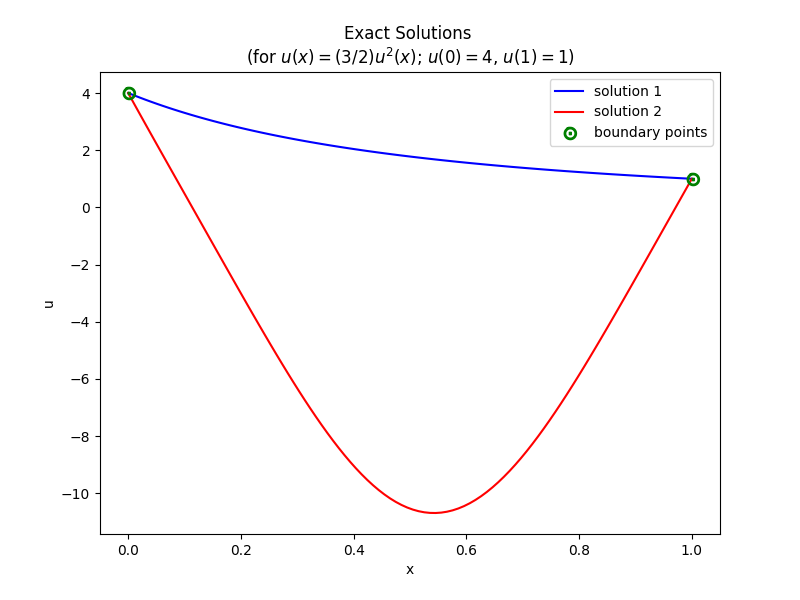

In [95]:
import numpy as np
from scipy.special import ellipj

exact1 = lambda x: 4/(1 + x)**2

def exact2(x):
    k = np.sqrt(2 + np.sqrt(3))/2
    c1 = 4.30310990
    c2 = 2.33464196
    sn, cn, dn, ph = ellipj(c1*x - c2, k*k)
    u2 = c1*c1*((1 - cn)/(1 + cn) - 1/np.sqrt(3))
    return u2
    
# setup grid
xmin = 0.0
xmax = 1.0
nxsteps = 100
x = np.linspace(xmin, xmax, nxsteps)

# plot the solutions
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.plot(x, exact1(x), 'b-', label='solution 1')
ax1.plot(x, exact2(x), 'r-', label='solution 2')
ax1.plot([xL, xR], [uL, uR],color='green', lw=0, marker=r'$\odot$', markersize=10, label='boundary points')
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Exact Solutions \n' \
               r'(for $u''(x)=(3/2)u^2(x)$; $u(0)=4$, $u(1)=1$)')
ax1.legend(loc='upper right', numpoints=1)
fig.show()

## 3. Reconnaissance (shotgun approach)

As discussed already, the shooting method is an example of a root finding problem. By its very nature, root finding is a local problem. As such, it is problematic to proceed blindly, without any local information about how a function behaves in certain neighborhoods or which root(s) we are trying to find. For that reason it helps to do a little reconnaissance before hand. Some methods (for example, bisection method) require that the desired root is bracketed between two initial guesses. Other methods (for example, Newton-Raphson) only require one initial guess, however they typically require that initial guess to be "close" to the correct answer. Either way, we need to know more about the behavior of the function in order to proceed.

So here let us explore the above bvp by trying a range of shooting solutions and see which ones get close to our target. After this "shotgun" experiment, we'll have a better idea of what regions of parameter space our solutions lie in. (Of course in this case we could also draw insight from the analytical solution above. But more often than not, we don't have an analytical solution to peek at.)

In [96]:
# set graphics backend
%matplotlib notebook

In [97]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt
from rk45_fehlberg import rk45f_step

In [98]:
### subroutines ###

# rhs function
def rhs(x, u):
    dudx = np.zeros(2)
    dudx[0] = u[1]
    dudx[1] = 1.5*u[0]*u[0]
    return dudx

# integrator
def get_soln(x, h, vel, rhs):
    # initialize output array
    u = np.zeros((2, nxsteps + 1))
    u[0,0] = uL
    u[1,0] = vel
    # initialize local error array
    lte = np.zeros_like(u)
    lte[0,0] = 0.0
    lte[1,0] = 0.0
    # integrate from xL to xR
    for j in range(0, nxsteps): 
        # call ode-step routine
        u[:,j+1], lte[:,j+1] = rk45f_step(x[j], u[:,j], rhs, h)
        # increment x
        x[j+1] = x[j] + h
    # get final value at right boundary
    # (using interpolation if necessary)
    uR_test = u[0,-1]
    # calculate residual
    res = uR_test - uR
    # return solution, error, and residual
    return u, lte, res

### setup ###

# setup grid
xmin = 0
xmax = 1
nxsteps = 100
h = (xmax - xmin)/nxsteps
x = np.linspace(xmin, xmax, nxsteps+1)

# boundary conditions
xL = xmin
xR = xmax
uL = 4.0
uR = 1.0

<IPython.core.display.Javascript object>


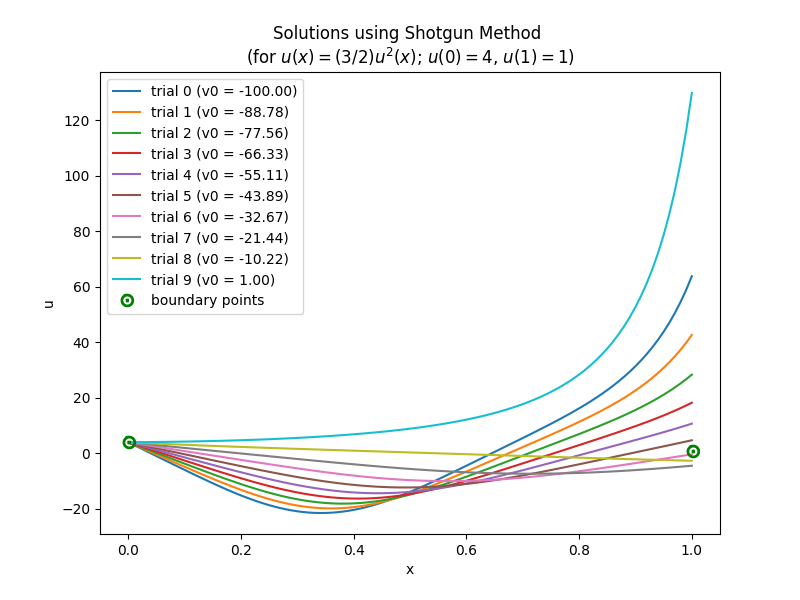

In [99]:
### initial reconnaissance ###
# choose range of initial "velocities"
vmax = 1
vmin = -100
ntrials = 10
vels = np.linspace(vmin, vmax, ntrials)
solns = np.zeros((ntrials, len(x)))
residuals = np.zeros(ntrials)

# fire away!
for i in range(ntrials):
    vel = vels[i]
    soln, err, res = get_soln(x, h, vel, rhs)
    solns[i, :] = soln[0]
    residuals[i] = res

# plot the solutions
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
for i in range(ntrials):
    ax1.plot(x, solns[i, :], label='trial %d (v0 = %.2f)' % (i, vels[i]))
ax1.plot([xL, xR], [uL, uR],color='green', lw=0, marker=r'$\odot$', markersize=10, label='boundary points')
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Solutions using Shotgun Method \n' \
               r'(for $u''(x)=(3/2)u^2(x)$; $u(0)=4$, $u(1)=1$)')
ax1.legend(loc='upper left', numpoints=1)
fig.show()

<IPython.core.display.Javascript object>


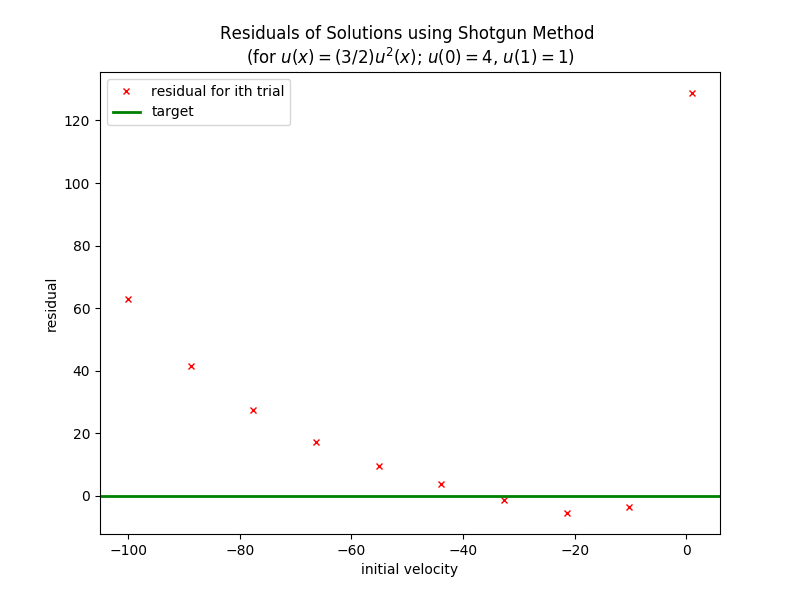

In [54]:
# plot the residuals
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.plot(vels[:], residuals[:], color='r', lw=0, \
         marker='x', markeredgewidth=1, markersize=4, label='residual for ith trial')
ax1.axhline(y=0, color='green', linewidth=2, label='target')
ax1.set_xlabel('initial velocity')
ax1.set_ylabel('residual')
ax1.set_title('Residuals of Solutions using Shotgun Method \n' \
               r'(for $u''(x)=(3/2)u^2(x)$; $u(0)=4$, $u(1)=1$)')
ax1.legend(loc='upper left', numpoints=1)
fig.show()

The above experiment shows that there are (at least) two solutions. One solution corresponds to an initial velocity somewhere in the interval [-45,-35], while the other is somewhere in the interval [-10,5]. We can now use this knowledge as the basis for a more careful search using the shooting method. (Again, some of this could have been gleaned from the analytical solution, but that is not always a luxury one has. Some form of "reconnaissance" is usually needed prior to any root finding task.)

## 4. CODE: Shooting Method

In [102]:
### apply shooting method ###

def shooting_method(v1, v2, TOL, IMAX):
    """
    Carries out shooting method for max number of iterations.
    If residual is greater than the given tolerance, a new 
    initial velocity is calculated using a Newton-Raphson scheme.
    
    INPUT
    v1   : initial velocity for trial 1
    v2   : initial velocity for trial 2
    TOL  : tolerance for residual
    IMAX : maximum number of iterations
    
    OUTPUT
    vels      : initial velocity used for each trial
    solns     : full integrated solutions for each trial
    errors    : local trucation error for each step of each trial
    residuals : residual for each trial
    itfinal   : final iteration number
    
    """
    
    # set max number of iterations
    itmax = IMAX

    # initialize output arrays
    vels = np.zeros(IMAX)
    solns = np.zeros((IMAX, len(x)))
    errors = np.zeros_like(solns)
    residuals = np.zeros(IMAX)

    # set initial "velocities"
    vels[0] = v1
    vels[1] = v2

    # fire away!
    for i in range(IMAX):
        # get initial velocity
        v = vels[i]
        print('Iteration', i, ':')
        print('Trying initial velocity of', v)
        # call integrator
        soln, err, res = get_soln(x, h, v, rhs)
        # save trial data
        solns[i, :] = soln[0] #WARNING: only keeping u(x), not u'(x)
        errors[i, :] = err[0] #WARNING: only keeping error in u(x), not u'(x)
        residuals[i] = res
        # test if residual is within tolerance
        if abs(res) < TOL:
            # if yes, stop
            print('Hit!')
            itfinal = i
            print('FINISHED: initial velocity', v, ', \n' \
                  '          residual', res, ', \n'\
                  '          obtained after', i, 'iterations')
            break
        else:
            # if no, adjust initial velocity and try again
            print('Miss!')
            print('Residual is', res)
            
            # using Newton-Raphson
            # set dv 
            #dv = 0.1 #WARNING: Using fixed value may lead to large roundoff error!!!
            dv = np.sqrt(2e-16)*v #suggested: sqrt(machine epsilon)*(previous v)
            # call integrator
            soln_dv, err_dv, res_dv = get_soln(x, h, v+dv, rhs)
            # calculate new initial velocity
            vnew = v - dv*res/(res_dv - res)
            vels[i+1] = vnew
            print('New initial velocity is', vnew, '\n')
    
    # print warning if max iterations has been reached
    if itfinal == IMAX:
        print('WARNING: max iteration number has been reached! Stopping.')
        
    return vels, solns, errors, residuals, itfinal

Iteration 0 :
Trying initial velocity of -45.0
Miss!
Residual is 4.244433527122372
New initial velocity is -36.40090568131111 

Iteration 1 :
Trying initial velocity of -36.40090568131111
Miss!
Residual is 0.23834010242516324
New initial velocity is -35.86036124870262 

Iteration 2 :
Trying initial velocity of -35.86036124870262
Hit!
FINISHED: initial velocity -35.86036124870262 , 
          residual 0.0007940530396604029 , 
          obtained after 2 iterations


<IPython.core.display.Javascript object>


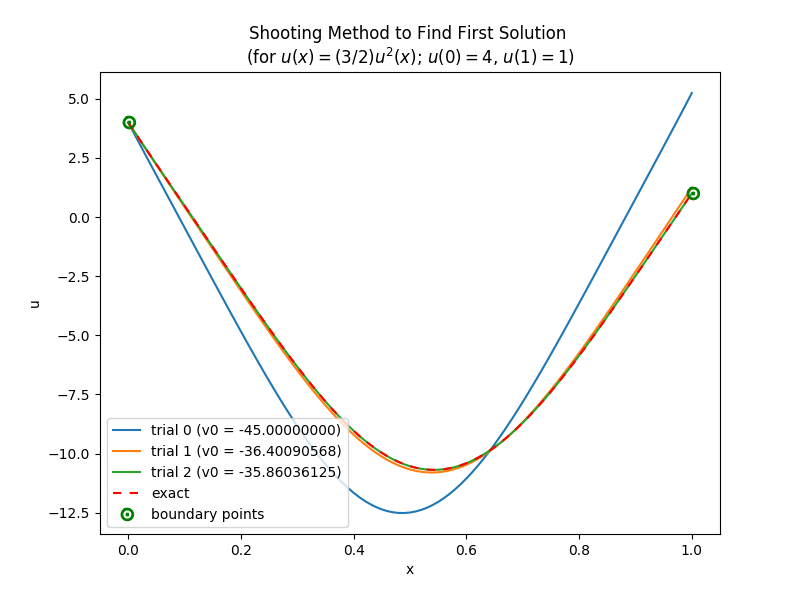

In [101]:
### first solution ###
data1 = shooting_method(-45.0, -35.0, 1e-3, 10)
vels1 = data1[0]
solns1 = data1[1]
errors1 = data1[2]
residuals1 = data1[3]
itfinal1 = data1[4]

# plot the results
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
for i in range(itfinal1 + 1):
    ax1.plot(x, solns1[i, :], label='trial %d (v0 = %.8f)' % (i, vels1[i]))
ax1.plot(x, exact2(x), 'r--', linestyle=(0, (4, 4, 4, 4)), label='exact')
ax1.plot([xL, xR], [uL, uR],color='green', lw=0, marker=r'$\odot$', markersize=10, label='boundary points')
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Shooting Method to Find First Solution \n' \
               r'(for $u''(x)=(3/2)u^2(x)$; $u(0)=4$, $u(1)=1$)')
ax1.legend(loc='lower left', numpoints=1)
fig.show()

Iteration 0 :
Trying initial velocity of -10.0
Miss!
Residual is -3.4008369371459435
New initial velocity is -7.233292536837227 

Iteration 1 :
Trying initial velocity of -7.233292536837227
Miss!
Residual is 1.954731896815717
New initial velocity is -7.918340017566716 

Iteration 2 :
Trying initial velocity of -7.918340017566716
Miss!
Residual is 0.1874799738698656
New initial velocity is -7.999008170452432 

Iteration 3 :
Trying initial velocity of -7.999008170452432
Miss!
Residual is 0.002249654996303363
New initial velocity is -7.9999998491665485 

Iteration 4 :
Trying initial velocity of -7.9999998491665485
Hit!
FINISHED: initial velocity -7.9999998491665485 , 
          residual 3.346314583207999e-07 , 
          obtained after 4 iterations


<IPython.core.display.Javascript object>


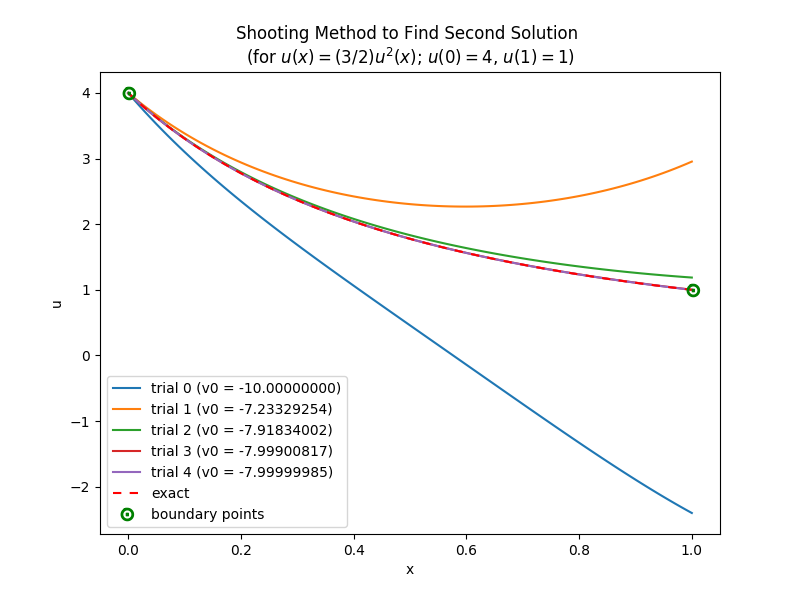

In [68]:
### second solution ###
data2 = shooting_method(-10.0, 10.0, 1e-3, 10)
vels2 = data2[0]
solns2 = data2[1]
errors2 = data2[2]
residuals2 = data2[3]
itfinal2 = data2[4]

# plot the results
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
for i in range(itfinal2 + 1):
    ax1.plot(x, solns2[i, :], label='trial %d (v0 = %.8f)' % (i, vels2[i]))
ax1.plot(x, exact1(x), 'r--', linestyle=(0,(4, 4, 4, 4)), label='exact')
ax1.plot([xL, xR], [uL, uR],color='green', lw=0, marker=r'$\odot$', markersize=10, label='boundary points')
ax1.set_xlabel('x')
ax1.set_ylabel('u')
ax1.set_title('Shooting Method to Find Second Solution \n' \
               r'(for $u''(x)=(3/2)u^2(x)$; $u(0)=4$, $u(1)=1$)')
ax1.legend(loc='lower left', numpoints=1)
fig.show()

## 5. Non-Dirichlet boundary conditions

Consider a second-order BVP with Neumann boundary conditions instead of Dirichlet boundary conditions.

\begin{align*}
  u''(x) = f(x, u(x), u'(x))
  \quad;\quad u'(a) = v_{a}
  \quad,\quad u'(b) = v_{b}.
\end{align*}

As before, let $u(x;s)$ denote a solution to a corresponding IVP, this time fixing $u'(a)$ by the boundary conditions and taking $u(a)$ as the free parameter.

\begin{align}
  u''(x) = f(x, u(x), u'(x))
  \quad;\quad u(a) = s
  \quad,\quad u'(a) = v_{a}.
\end{align}

Define the residual function

\begin{align}
  F(s) \equiv u'(b;s) - v_{b}.
\end{align}

Note that this is defined in terms of the derivative $u'(b)\equiv v(b)$ instead of $u(b)$ as we did for Dirichlet boundary conditions. So essentially, the method is the same but for the swapping of roles of $u$ and $v$, let's call them "height" and "velocity" (in analogy to a free fall problem in physics). Instead of varying the initial velocity at one boundary until we hit the desired height at the other, here we vary the initial height at one boundary until we acheive the desired velocity at the other.

In [93]:
### subroutines ###

# rhs function
def rhs(x, u):
    dudx = np.zeros(2)
    dudx[0] = u[1]
    dudx[1] = 1.5*u[0]*u[0]
    return dudx

# integrator for Neumann boundary conditions
def get_soln(x, h, pos, rhs):
    # initialize output array
    u = np.zeros((2, nxsteps + 1))
    u[0,0] = pos
    u[1,0] = u_prime_L
    # initialize local error array
    lte = np.zeros_like(u)
    lte[0,0] = 0.0
    lte[1,0] = 0.0
    # integrate from xL to xR
    for j in range(0, nxsteps): 
        # call ode-step routine
        u[:,j+1], lte[:,j+1] = rk45f_step(x[j], u[:,j], rhs, h)
        # increment x
        x[j+1] = x[j] + h
    # get final value of derivative at right boundary
    # (using interpolation if necessary)
    u_prime_R_test = u[1,-1]
    # calculate residual
    res = u_prime_R_test - u_prime_R
    # return solution, error, and residual
    return u, lte, res

### setup ###

# setup grid
xmin = 0
xmax = 1
nxsteps = 100
h = (xmax - xmin)/nxsteps
x = np.linspace(xmin, xmax, nxsteps+1)

### boundary conditions ###
xL = xmin
xR = xmax

# Dirichlet
#uL = g1
#uR = g2

# Neumann
u_prime_L = g1
u_prime_R = g2

# mixed, case 1
#uL = g1
#u_prime_R = g2

# mixed, case 2
#u_prime_L = g1
#uR = g2

<IPython.core.display.Javascript object>


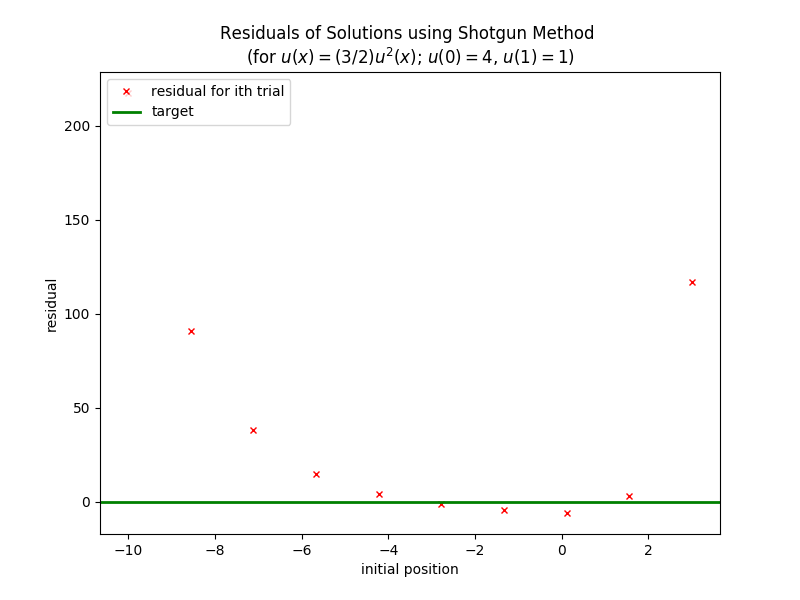

In [94]:
### initial reconnaissance ###
# choose range of initial "positions"
pmax = 3
pmin = -10
ntrials = 10
posits = np.linspace(pmin, pmax, ntrials)
solns = np.zeros((ntrials, len(x)))
residuals = np.zeros(ntrials)

# fire away!
for i in range(ntrials):
    pos = posits[i]
    soln, err, res = get_soln(x, h, pos, rhs)
    solns[i, :] = soln[0]
    residuals[i] = res

# plot the residuals
fig, ax1 = plt.subplots(1,1, figsize=(8, 6))
ax1.plot(posits[:], residuals[:], color='r', lw=0, \
         marker='x', markeredgewidth=1, markersize=4, label='residual for ith trial')
ax1.axhline(y=0, color='green', linewidth=2, label='target')
ax1.set_xlabel('initial position')
ax1.set_ylabel('residual')
ax1.set_title('Residuals of Solutions using Shotgun Method \n' \
               r'(for $u''(x)=(3/2)u^2(x)$; $u(0)=4$, $u(1)=1$)')
ax1.legend(loc='upper left', numpoints=1)
fig.show()

In [ ]:
### apply shooting method ###

def shooting_method_mixed(g1, g2, TOL, IMAX):
    """
    Carries out shooting method for max number of iterations.
    If residual is greater than the given tolerance, a new 
    initial velocity is calculated using a Newton-Raphson scheme.
    
    INPUT
    v1   : initial velocity for trial 1
    v2   : initial velocity for trial 2
    TOL  : tolerance for residual
    IMAX : maximum number of iterations
    
    OUTPUT
    vels      : initial velocity used for each trial
    solns     : full integrated solutions for each trial
    errors    : local trucation error for each step of each trial
    residuals : residual for each trial
    itfinal   : final iteration number
    
    """
    
    # set max number of iterations
    itmax = IMAX

    # initialize output arrays
    vels = np.zeros(IMAX)
    solns = np.zeros((IMAX, len(x)))
    errors = np.zeros_like(solns)
    residuals = np.zeros(IMAX)

    # set initial "velocities"
    vels[0] = v1
    vels[1] = v2

    # fire away!
    for i in range(IMAX):
        # get initial velocity
        v = vels[i]
        print('Iteration', i, ':')
        print('Trying initial velocity of', v)
        # call integrator
        soln, err, res = get_soln(x, h, v, rhs)
        # save trial data
        solns[i, :] = soln[0] #WARNING: only keeping u(x), not u'(x)
        errors[i, :] = err[0] #WARNING: only keeping error in u(x), not u'(x)
        residuals[i] = res
        # test if residual is within tolerance
        if abs(res) < TOL:
            # if yes, stop
            print('Hit!')
            itfinal = i
            print('FINISHED: initial velocity', v, ', \n' \
                  '          residual', res, ', \n'\
                  '          obtained after', i, 'iterations')
            break
        else:
            # if no, adjust initial velocity and try again
            print('Miss!')
            print('Residual is', res)
            
            # using Newton-Raphson
            # set dv 
            #dv = 0.1 #WARNING: Using fixed value may lead to large roundoff error!!!
            dv = np.sqrt(2e-16)*v #suggested: sqrt(machine epsilon)*(previous v)
            # call integrator
            soln_dv, err_dv, res_dv = get_soln(x, h, v+dv, rhs)
            # calculate new initial velocity
            vnew = v - dv*res/(res_dv - res)
            vels[i+1] = vnew
            print('New initial velocity is', vnew, '\n')
    
    # print warning if max iterations has been reached
    if itfinal == IMAX:
        print('WARNING: max iteration number has been reached! Stopping.')
        
    return vels, solns, errors, residuals, itfinal

## 6. Shooting method for systems of equations

One important extension of the simple shooting method is to accommodate systems of equations. For example, we may have a boundary value problem for two or more quantities. As an example, consider 



## 7.Multiple shooting

We have mentioned in passing that the shooting method is somewhat prone to the accumulation of round-off error. A common experience is to find that the shooting solutions blow up as the target boundary is approached. This will almost certainly be the case when shooting *towards* a singular point in the underlying equations. In that case the possible remedy is to instead shoot *away from* the singular boundary and *towards* the non-singular boundary.
Then the "simple" shooting method can still be used (swapping the roles of the two boundaries). Essentially the problem is circumvented by starting the integration at (near) the boundary where solutions are more sensitive to round-off error and hoping to sprint out of the danger zone before getting burnt (that is before your solutions are rendered useless by round-off error). 

However, being overrun by round-off error can happen anytime the solutions rise or fall rapidly, whether or not the equations are singular at the boundaries. In other situations, the equations may contain singularities at both boundaries. Either way, one faces the difficulty that shooting toward either boundary leads to blowing up shooting solutions? What to do?

The remedy is to shoot *away* from *both* boundaries toward a common matching point somewhere in the interior of the grid. If there are problematic points in the interior, one can conceive of multiple shooting solutions from several points throughout the interval, towards various matching points. One iterates until $u(x)$ and $u'(x)$ match at all of the fitting points. We won't go into the details here. Hopefully the idea is clear enough. If you are faced with a boundary value problem of this kind, see Keller [4] for a detailed discussion. (NOTE: another prudent option is to look for a more stable method, such as relaxation methods.)